### Test notebook for OD experiments


In [1]:
# Perform imports
import torch
import numpy as np
from torchvision.models import detection
from torchvision.datasets import CocoDetection
from matplotlib import pyplot as plt
import cv2
from tqdm.notebook import tqdm
import signal
from datetime import datetime
from torch.utils.data import DataLoader, Dataset
import os
from src.evaluators.pascal_voc_evaluator import get_pascalvoc_metrics
from src.utils.enumerators import MethodAveragePrecision
from src.bounding_box import BoundingBox, BBType, BBFormat
from itertools import chain
import json
import pandas as pd
from IPython.display import display
# Global config
%load_ext line_profiler

plt.rcParams['figure.figsize'] = (20, 10)


In [6]:
# determine device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on", DEVICE)

COCO_LABELS = [
    'person',
    'bicycle',
    'car',
    'motorcycle',
    'airplane',
    'bus',
    'train',
    'truck',
    'boat',
    'traffic light',
    'fire hydrant',
    'street sign',
    'stop sign',
    'parking meter',
    'bench',
    'bird',
    'cat',
    'dog',
    'horse',
    'sheep',
    'cow',
    'elephant',
    'bear',
    'zebra',
    'giraffe',
    'hat',
    'backpack',
    'umbrella',
    'shoe',
    'eye glasses',
    'handbag',
    'tie',
    'suitcase',
    'frisbee',
    'skis',
    'snowboard',
    'sports ball',
    'kite',
    'baseball bat',
    'baseball glove',
    'skateboard',
    'surfboard',
    'tennis racket',
    'bottle',
    'plate',
    'wine glass',
    'cup',
    'fork',
    'knife',
    'spoon',
    'bowl',
    'banana',
    'apple',
    'sandwich',
    'orange',
    'broccoli',
    'carrot',
    'hot dog',
    'pizza',
    'donut',
    'cake',
    'chair',
    'couch',
    'potted plant',
    'bed',
    'mirror',
    'dining table',
    'window',
    'desk',
    'toilet',
    'door',
    'tv',
    'laptop',
    'mouse',
    'remote',
    'keyboard',
    'cell phone',
    'microwave',
    'oven',
    'toaster',
    'sink',
    'refrigerator',
    'blender',
    'book',
    'clock',
    'vase',
    'scissors',
    'teddy bear',
    'hair drier',
    'toothbrush',
    'hair brush',
]

COLORS = np.random.uniform(0, 255, size=(len(COCO_LABELS), 3))

LABEL_DICT = {
    'car': 'vehicle',
    'bus': 'vehicle',
    'truck': 'vehicle',
    'caravan': 'vehicle',
    'trailer': 'vehicle',
    'motorcycle': 'vehicle',
    'train': 'vehicle',
    'bicycle': 'vehicle',
    'person': 'pedestrian',
    'rider': 'pedestrian',
}

# Use pretrained model frcnn-mobilenet
model = detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True, progress=True,
                                                        num_classes=len(COCO_LABELS), pretrained_backbone=True).to(DEVICE)


Running on cpu


### Test model with a single image


In [108]:
def preprocess(image):
    image = image.transpose((2, 0, 1))

    # Reformat image data
    image = np.expand_dims(image, axis=0)
    image = image / 255.0
    image = torch.FloatTensor(image)
    image = torch.squeeze(image, 0)

    # Move data to correct device
    return image.to(DEVICE, non_blocking=True)


def draw_detections(image, detections, tol):
    # Loop over detections
    for i in range(0, len(detections["boxes"])):
        score = detections["scores"][i]

        # Ignore any detections below the tolerance
        if score > tol:
            # Pull important data
            idx = int(detections["labels"][i])
            cat = get_cat(idx)
            box = detections["boxes"][i].detach().cpu().numpy()
            (x0, y0, x1, y1) = box.astype("int")
            label = "{}: {:.2f}%".format(cat['name'], score * 100)

            # draw the bounding box and label on the image
            cv2.rectangle(image, (x0, y0), (x1, y1),
                          COLORS[idx], 2)
            y = y0 - 15 if y0 - 15 > 15 else y0 + 15
            cv2.putText(image, label, (x0, y),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)

    return image


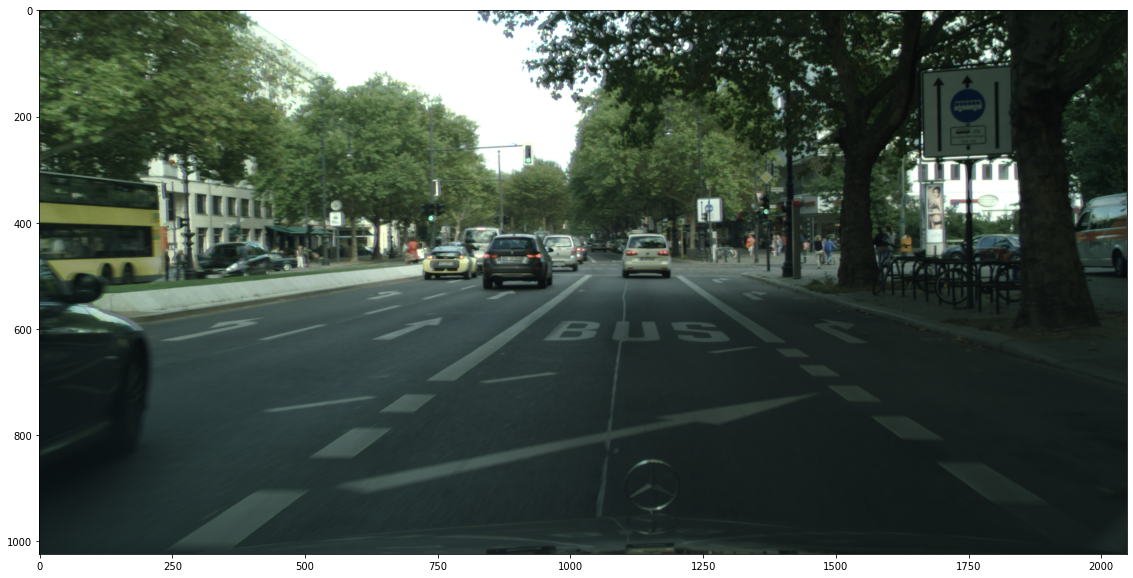

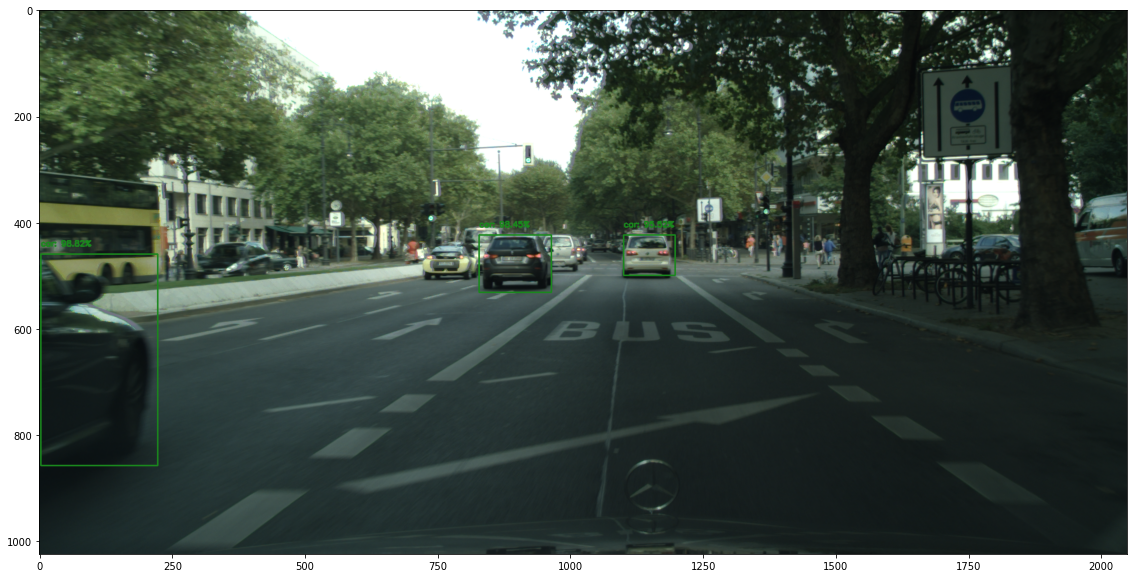

In [109]:
# Load test image
image = cv2.imread(
    "data/datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000000_000019_leftImg8bit.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

orig = image.copy()

plt.imshow(image)
plt.show()


image = preprocess(image)
result = model([image])

detections = result[0]

box_image = draw_detections(orig, detections, 0.8)

plt.imshow(box_image)
plt.show()


### Run on video


In [5]:
# Prepare video
class VideoDataset(Dataset):

    def __init__(self, vid_path):
        self.vid_path = vid_path
        self.cap = cv2.VideoCapture(vid_path)

    def __len__(self):
        return int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))

    def __getitem__(self, idx):
        frame = self.get_frame(idx)
        orig = frame.copy()
        data = preprocess(frame)

        return orig, data

    def get_frame(self, idx):
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        _, frame = self.cap.read()

        return frame


In [110]:
# Get reference to video
def video():
    model.eval()
    # batch_size = 8
    # video_dataset = VideoDataset('data/highway_video.mp4')

    # video_dataloader = DataLoader(
    #     video_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)
    
    cap = cv2.VideoCapture('data/highway_video.mp4')
    # cap = video_dataset.cap
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Get video format
    fourcc = int(cap.get(cv2.CAP_PROP_FOURCC))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Create video writer
    vwriter = cv2.VideoWriter()
    vwriter.open(
        f'data/outputs/highway_video_out_{datetime.now().isoformat()}.mp4', fourcc, fps, (w, h), True)


    def signal_handler(sig, _):
        print('SIGINT recieved')
        global sig_int
        sig_int = True


    signal.signal(signal.SIGINT, signal_handler)

    # Loop through video
    global sig_int
    sig_int = False
    ret = True
    with tqdm(total=num_frames+1) as pbar:
        while(ret):
            # Get frame and pre process
            ret, frame = cap.read()
            img = frame.copy()

            if ret == False:
                break

            img = np.array(img)
            img = img.transpose((2, 0, 1))
            img = img / 255.0
            img = torch.FloatTensor(img)
            img = img.to(DEVICE)

            results = model([img])

            for i, detections in enumerate(results):
                out = draw_detections(frame, detections, 0.5)
                vwriter.write(out)

            if sig_int:
                break

            pbar.update(1)




    # Release both input and output videos
    cap.release()
    vwriter.release()

# %lprun -T video_prof.txt -f video video()
video()


  0%|          | 0/9185 [00:00<?, ?it/s]

SIGINT recieved


### Cityscapes Finetuning

In [7]:
CITYSCAPES_ROOT = 'data/datasets/Cityscapes'
train = CocoDetection(os.path.join(CITYSCAPES_ROOT), os.path.join(
    CITYSCAPES_ROOT, 'annotations/instancesonly_filtered_gtFine_train.json'))

CITYSCAPES_ROOT = 'data/datasets/Cityscapes'
val = CocoDetection(os.path.join(CITYSCAPES_ROOT), os.path.join(
    CITYSCAPES_ROOT, 'annotations/instancesonly_filtered_gtFine_val.json'))

COCO_cats = [{"supercategory": "person", "id": 1, "name": "person"}, {"supercategory": "vehicle", "id": 2, "name": "bicycle"}, {"supercategory": "vehicle", "id": 3, "name": "car"}, {"supercategory": "vehicle", "id": 4, "name": "motorcycle"}, {"supercategory": "vehicle", "id": 5, "name": "airplane"}, {"supercategory": "vehicle", "id": 6, "name": "bus"}, {"supercategory": "vehicle", "id": 7, "name": "train"}, {"supercategory": "vehicle", "id": 8, "name": "truck"}, {"supercategory": "vehicle", "id": 9, "name": "boat"}, {"supercategory": "outdoor", "id": 10, "name": "traffic light"}, {"supercategory": "outdoor", "id": 11, "name": "fire hydrant"}, {"supercategory": "outdoor", "id": 13, "name": "stop sign"}, {"supercategory": "outdoor", "id": 14, "name": "parking meter"}, {"supercategory": "outdoor", "id": 15, "name": "bench"}, {"supercategory": "animal", "id": 16, "name": "bird"}, {"supercategory": "animal", "id": 17, "name": "cat"}, {"supercategory": "animal", "id": 18, "name": "dog"}, {"supercategory": "animal", "id": 19, "name": "horse"}, {"supercategory": "animal", "id": 20, "name": "sheep"}, {"supercategory": "animal", "id": 21, "name": "cow"}, {"supercategory": "animal", "id": 22, "name": "elephant"}, {"supercategory": "animal", "id": 23, "name": "bear"}, {"supercategory": "animal", "id": 24, "name": "zebra"}, {"supercategory": "animal", "id": 25, "name": "giraffe"}, {"supercategory": "accessory", "id": 27, "name": "backpack"}, {"supercategory": "accessory", "id": 28, "name": "umbrella"}, {"supercategory": "accessory", "id": 31, "name": "handbag"}, {"supercategory": "accessory", "id": 32, "name": "tie"}, {"supercategory": "accessory", "id": 33, "name": "suitcase"}, {"supercategory": "sports", "id": 34, "name": "frisbee"}, {"supercategory": "sports", "id": 35, "name": "skis"}, {"supercategory": "sports", "id": 36, "name": "snowboard"}, {"supercategory": "sports", "id": 37, "name": "sports ball"}, {"supercategory": "sports", "id": 38, "name": "kite"}, {"supercategory": "sports", "id": 39, "name": "baseball bat"}, {"supercategory": "sports", "id": 40, "name": "baseball glove"}, {"supercategory": "sports", "id": 41, "name": "skateboard"}, {"supercategory": "sports", "id": 42, "name": "surfboard"}, {"supercategory": "sports", "id": 43, "name": "tennis racket"}, {"supercategory": "kitchen", "id": 44, "name": "bottle"}, {
    "supercategory": "kitchen", "id": 46, "name": "wine glass"}, {"supercategory": "kitchen", "id": 47, "name": "cup"}, {"supercategory": "kitchen", "id": 48, "name": "fork"}, {"supercategory": "kitchen", "id": 49, "name": "knife"}, {"supercategory": "kitchen", "id": 50, "name": "spoon"}, {"supercategory": "kitchen", "id": 51, "name": "bowl"}, {"supercategory": "food", "id": 52, "name": "banana"}, {"supercategory": "food", "id": 53, "name": "apple"}, {"supercategory": "food", "id": 54, "name": "sandwich"}, {"supercategory": "food", "id": 55, "name": "orange"}, {"supercategory": "food", "id": 56, "name": "broccoli"}, {"supercategory": "food", "id": 57, "name": "carrot"}, {"supercategory": "food", "id": 58, "name": "hot dog"}, {"supercategory": "food", "id": 59, "name": "pizza"}, {"supercategory": "food", "id": 60, "name": "donut"}, {"supercategory": "food", "id": 61, "name": "cake"}, {"supercategory": "furniture", "id": 62, "name": "chair"}, {"supercategory": "furniture", "id": 63, "name": "couch"}, {"supercategory": "furniture", "id": 64, "name": "potted plant"}, {"supercategory": "furniture", "id": 65, "name": "bed"}, {"supercategory": "furniture", "id": 67, "name": "dining table"}, {"supercategory": "furniture", "id": 70, "name": "toilet"}, {"supercategory": "electronic", "id": 72, "name": "tv"}, {"supercategory": "electronic", "id": 73, "name": "laptop"}, {"supercategory": "electronic", "id": 74, "name": "mouse"}, {"supercategory": "electronic", "id": 75, "name": "remote"}, {"supercategory": "electronic", "id": 76, "name": "keyboard"}, {"supercategory": "electronic", "id": 77, "name": "cell phone"}, {"supercategory": "appliance", "id": 78, "name": "microwave"}, {"supercategory": "appliance", "id": 79, "name": "oven"}, {"supercategory": "appliance", "id": 80, "name": "toaster"}, {"supercategory": "appliance", "id": 81, "name": "sink"}, {"supercategory": "appliance", "id": 82, "name": "refrigerator"}, {"supercategory": "indoor", "id": 84, "name": "book"}, {"supercategory": "indoor", "id": 85, "name": "clock"}, {"supercategory": "indoor", "id": 86, "name": "vase"}, {"supercategory": "indoor", "id": 87, "name": "scissors"}, {"supercategory": "indoor", "id": 88, "name": "teddy bear"}, {"supercategory": "indoor", "id": 89, "name": "hair drier"}, {"supercategory": "indoor", "id": 90, "name": "toothbrush"}]

def get_cat(id):
    return next(item for item in COCO_cats if item["id"] == id)


def find_cat_by_name(name):
    if (name in COCO_LABELS):
        return next(item for item in COCO_cats if item["name"] == name)
    else:
        return None


def ann_to_target(ann, cats):
    num_objs = len(ann)

    if num_objs == 0:
        return None

    boxes = []
    for i in range(num_objs):
        xmin = ann[i]['bbox'][0]
        ymin = ann[i]['bbox'][1]
        xmax = xmin + ann[i]['bbox'][2]
        ymax = ymin + ann[i]['bbox'][3]
        boxes.append([xmin, ymin, xmax, ymax])
    boxes = torch.as_tensor(boxes, dtype=torch.float32)

    labels = []
    for i in range(num_objs):
        cat_id = ann[i]['category_id']
        if cat_id != 0:
            cat = cats[cat_id]
            cat_name = cat['name']

            # Relabel rider as person
            if cat_name == 'rider':
                cat_name = 'person'

            new_cat = find_cat_by_name(cat_name)
            cat_id = new_cat['id']

            if new_cat['name'] != cat_name:
                print('Mismatch!')

        labels.append(cat_id)
    labels = torch.as_tensor(labels, dtype=torch.int64)

    img_id = torch.tensor(ann[0]['image_id'])

    areas = []
    for i in range(num_objs):
        areas.append(ann[i]['area'])
    areas = torch.as_tensor(areas, dtype=torch.float32)

    iscrowd = []
    for i in range(num_objs):
        iscrowd.append(ann[i]['iscrowd'])
    iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)

    # Annotation is in dictionary format
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = img_id
    target["area"] = areas
    target["iscrowd"] = iscrowd

    return target

def collate_fn(batch, cats):
    images = []
    targets = []
    for data in batch:
        img, ann = data
        
        img = np.array(img)
        img = img.transpose((2, 0, 1))
        img = img / 255.0
        img = torch.FloatTensor(img)
        img = img.to(DEVICE)

        target = ann_to_target(ann, cats)

        if target == None:
            continue

        images.append(img)
        targets.append(target)

    return (images, targets)

def train_collate_fn(batch):
    return collate_fn(batch, train.coco.cats)

def val_collate_fn(batch):
    return collate_fn(batch, val.coco.cats)

BATCH_SIZE = 4

train_dataloader = DataLoader(
    train, batch_size=BATCH_SIZE, shuffle=False, collate_fn=train_collate_fn)

val_dataloader = DataLoader(
    val, batch_size=BATCH_SIZE, shuffle=False, collate_fn=val_collate_fn)

loading annotations into memory...
Done (t=2.46s)
creating index...
index created!
loading annotations into memory...
Done (t=0.83s)
creating index...
index created!


In [130]:
model.train()

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

with tqdm(total=len(train_dataloader) * BATCH_SIZE) as pbar:
        for i, batch in enumerate(train_dataloader):
            imgs, targets = batch            

            if len(targets) != 0:
                loss_dict = model(imgs, targets)

                losses = sum(loss for loss in loss_dict.values())

                optimizer.zero_grad()
                losses.backward()
                optimizer.step()

                print(f'Iteration: {i}, Loss: {losses}')

            pbar.update(BATCH_SIZE)



  0%|          | 0/2976 [00:00<?, ?it/s]

Iteration: 0, Loss: 0.5831426382064819
Iteration: 1, Loss: 0.7064895033836365
Iteration: 2, Loss: 0.6599970459938049
Iteration: 3, Loss: 0.9051779508590698
Iteration: 4, Loss: 0.7398564219474792
Iteration: 5, Loss: 0.7164551019668579
Iteration: 6, Loss: 0.7737388014793396
Iteration: 7, Loss: 0.6284196376800537
Iteration: 8, Loss: 0.5752243995666504
Iteration: 9, Loss: 0.7915300130844116
Iteration: 10, Loss: 0.7495919466018677
Iteration: 11, Loss: 1.0129539966583252
Iteration: 12, Loss: 0.7244030237197876
Iteration: 13, Loss: 0.9581613540649414
Iteration: 14, Loss: 0.7695162296295166
Iteration: 15, Loss: 0.9747053980827332
Iteration: 16, Loss: 1.1055949926376343
Iteration: 17, Loss: 1.0204722881317139
Iteration: 18, Loss: 0.7507290840148926
Iteration: 19, Loss: 0.8842304944992065
Iteration: 20, Loss: 0.6739307641983032
Iteration: 21, Loss: 1.0029263496398926
Iteration: 22, Loss: 0.9845362901687622
Iteration: 23, Loss: 0.8612658381462097
Iteration: 24, Loss: 0.8948248028755188
Iteration:

FileNotFoundError: [Errno 2] No such file or directory: '/models/modelv1'

In [132]:
torch.save(model, 'models/model_v2.0')

In [2]:
model = torch.load('models/model_v2.0')

In [9]:
def from_dict_to_boundingbox(file: dict, name: str, groundtruth: bool = True):
    """Returns list of BoundingBox objects from groundtruth or prediction."""
    labels = file["labels"]
    boxes = file["boxes"]
    scores = np.array(file["scores"].cpu().detach()) if not groundtruth else [None] * len(boxes)

    gt = BBType.GROUND_TRUTH if groundtruth else BBType.DETECTED

    return [
        BoundingBox(
            image_name=name,
            class_id=int(l),
            coordinates=tuple(torch.round(bb)),
            format=BBFormat.XYX2Y2,
            bb_type=gt,
            confidence=s,
        )
        for bb, l, s in zip(boxes, labels, scores)
    ]


model.eval()

all_gt_boxes = []
all_pred_boxes = []


with tqdm(total=len(val_dataloader) * BATCH_SIZE) as pbar:
        for batch in val_dataloader:
            imgs, targets = batch            

            if len(targets) != 0:
                image_id = targets[0]['image_id'].item()

                preds = model(imgs)
                gt_boxes = [from_dict_to_boundingbox(target, name=image_id, groundtruth=True) for target in targets]
                pred_boxes = [from_dict_to_boundingbox(pred, name=image_id, groundtruth=False) for pred in preds]

                all_gt_boxes.extend(gt_boxes)
                all_pred_boxes.extend(pred_boxes)

            pbar.update(BATCH_SIZE)

gt_boxes = list(chain(*all_gt_boxes))
pred_boxes = list(chain(*all_pred_boxes))


metric = get_pascalvoc_metrics(gt_boxes=gt_boxes,
                                det_boxes=pred_boxes,
                                iou_threshold=0.5,
                                method=MethodAveragePrecision.EVERY_POINT_INTERPOLATION,
                                generate_table=True)

class CustomEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()

        if isinstance(obj, MethodAveragePrecision):
            return 'EVERY_POINT_INTERPOLATION'

        if isinstance(obj, pd.DataFrame):
            return obj.to_json()
        return json.JSONEncoder.default(self, obj)

per_class, mAP = metric['per_class'], metric['mAP']

print(mAP)

val_results = json.dumps({'per_class': per_class, 'mAP': mAP}, cls=CustomEncoder)
with open('val_results.json', 'w') as outfile:
    outfile.write(val_results)


In [23]:
for obj_class in per_class:
  print(COCO_cats[obj_class]['name'])
  display(per_class[obj_class]['table'])

bicycle


,image,confidence,TP,FP,acc TP,acc FP,precision,recall
0,3107,99.97%,1,0,1.0,0.0,1.000000,0.000263
1,3007,99.95%,1,0,2.0,0.0,1.000000,0.000526
2,3347,99.94%,1,0,3.0,0.0,1.000000,0.000790
3,3211,99.94%,1,0,4.0,0.0,1.000000,0.001053
4,3415,99.94%,1,0,5.0,0.0,1.000000,0.001316
...,...,...,...,...,...,...,...,...
4799,3099,5.01%,0,1,1005.0,3795.0,0.209375,0.264543
4800,3259,5.01%,0,1,1005.0,3796.0,0.209331,0.264543
4801,3415,5.01%,0,1,1005.0,3797.0,0.209288,0.264543
4802,3163,5.01%,0,1,1005.0,3798.0,0.209244,0.264543


motorcycle


,image,confidence,TP,FP,acc TP,acc FP,precision,recall
0,3047,99.86%,1,0,1.0,0.0,1.000000,0.000221
1,3035,99.86%,1,0,2.0,0.0,1.000000,0.000442
2,3347,99.83%,1,0,3.0,0.0,1.000000,0.000663
3,3199,99.82%,1,0,4.0,0.0,1.000000,0.000884
4,3395,99.80%,1,0,5.0,0.0,1.000000,0.001105
...,...,...,...,...,...,...,...,...
5576,3051,5.01%,0,1,1780.0,3797.0,0.319168,0.393457
5577,3463,5.01%,0,1,1780.0,3798.0,0.319111,0.393457
5578,3219,5.01%,0,1,1780.0,3799.0,0.319054,0.393457
5579,3283,5.00%,0,1,1780.0,3800.0,0.318996,0.393457


train


,image,confidence,TP,FP,acc TP,acc FP,precision,recall
0,3031,99.95%,1,0,1.0,0.0,1.000000,0.010309
1,3131,99.94%,1,0,2.0,0.0,1.000000,0.020619
2,3279,99.90%,1,0,3.0,0.0,1.000000,0.030928
3,3079,99.83%,1,0,4.0,0.0,1.000000,0.041237
4,3251,99.79%,1,0,5.0,0.0,1.000000,0.051546
...,...,...,...,...,...,...,...,...
247,3131,5.14%,0,1,44.0,204.0,0.177419,0.453608
248,3043,5.10%,0,1,44.0,205.0,0.176707,0.453608
249,3335,5.06%,0,1,44.0,206.0,0.176000,0.453608
250,3087,5.05%,0,1,44.0,207.0,0.175299,0.453608


car


,image,confidence,TP,FP,acc TP,acc FP,precision,recall
0,3091,99.76%,1,0,1.0,0.0,1.000000,0.000897
1,3091,99.73%,1,0,2.0,0.0,1.000000,0.001794
2,3395,99.62%,1,0,3.0,0.0,1.000000,0.002691
3,3239,99.55%,1,0,4.0,0.0,1.000000,0.003587
4,3299,99.51%,1,0,5.0,0.0,1.000000,0.004484
...,...,...,...,...,...,...,...,...
949,3099,5.02%,0,1,220.0,730.0,0.231579,0.197309
950,2999,5.01%,1,0,221.0,730.0,0.232387,0.198206
951,3075,5.01%,0,1,221.0,731.0,0.232143,0.198206
952,3363,5.01%,0,1,221.0,732.0,0.231899,0.198206


boat


,image,confidence,TP,FP,acc TP,acc FP,precision,recall
0,3251,99.82%,1,0,1.0,0.0,1.000000,0.010870
1,3299,99.78%,1,0,2.0,0.0,1.000000,0.021739
2,3303,99.53%,1,0,3.0,0.0,1.000000,0.032609
3,3007,98.26%,0,1,3.0,1.0,0.750000,0.032609
4,3203,97.89%,1,0,4.0,1.0,0.800000,0.043478
...,...,...,...,...,...,...,...,...
1173,3059,5.04%,0,1,35.0,1139.0,0.029813,0.380435
1174,3063,5.04%,0,1,35.0,1140.0,0.029787,0.380435
1175,3007,5.04%,0,1,35.0,1141.0,0.029762,0.380435
1176,2975,5.04%,0,1,35.0,1142.0,0.029737,0.380435


airplane


,image,confidence,TP,FP,acc TP,acc FP,precision,recall
0,3395,98.77%,1,0,1.0,0.0,1.000000,0.006993
1,3243,96.84%,1,0,2.0,0.0,1.000000,0.013986
2,3411,96.82%,1,0,3.0,0.0,1.000000,0.020979
3,2999,93.24%,1,0,4.0,0.0,1.000000,0.027972
4,3243,93.16%,1,0,5.0,0.0,1.000000,0.034965
...,...,...,...,...,...,...,...,...
412,3011,5.05%,0,1,29.0,384.0,0.070218,0.202797
413,3071,5.04%,0,1,29.0,385.0,0.070048,0.202797
414,3223,5.03%,0,1,29.0,386.0,0.069880,0.202797
415,3411,5.01%,0,1,29.0,387.0,0.069712,0.202797


truck


,image,confidence,TP,FP,acc TP,acc FP,precision,recall
0,3455,72.76%,1,0,1.0,0.0,1.000000,0.045455
1,3427,46.34%,0,1,1.0,1.0,0.500000,0.045455
2,3323,31.61%,1,0,2.0,1.0,0.666667,0.090909
3,3427,26.25%,0,1,2.0,2.0,0.500000,0.090909
4,3243,21.95%,0,1,2.0,3.0,0.400000,0.090909
5,3367,17.99%,0,1,2.0,4.0,0.333333,0.090909
6,3363,16.40%,0,1,2.0,5.0,0.285714,0.090909
7,3335,16.15%,0,1,2.0,6.0,0.250000,0.090909
8,3391,12.05%,1,0,3.0,6.0,0.333333,0.136364
9,3331,11.63%,0,1,3.0,7.0,0.300000,0.136364


In [1]:
def show_bb(dataset, detections: list[list[BoundingBox]], index):
  image = dataset[index][0]
  image = np.array(image)

  confidences = []
  for detection in detections[index]:
    bb = detection.get_absolute_bounding_box(BBFormat.XYX2Y2)
    x1, y1, x2, y2 = tuple(int(pt) for pt in bb)
    p1 = (x1, y1)
    p2 = (x2, y2)
    class_id = detection.get_class_id()
    obj_class = get_cat(class_id)

    confidences.append(detection.get_confidence())

    image = cv2.rectangle(image, p1, p2, COLORS[obj_class['id']], 2)
    image = cv2.putText(image, obj_class['name'], (p1[0], p1[1] + 1), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 255, 255))

  plt.imshow(image)
  plt.show()

  print(sum(confidences)/ len(confidences))
show_bb(val, all_pred_boxes, 0)


NameError: name 'BoundingBox' is not defined